## Feature set 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,merge,Activation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


#### Extracting data from csv files into numpy arrays

In [2]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
files_data=np.array(['fold_data_1.csv','fold_data_2.csv','fold_data_3.csv','fold_data_4.csv','fold_data_5.csv',
                'fold_data_6.csv','fold_data_7.csv','fold_data_8.csv','fold_data_9.csv','fold_data_10.csv'])
X_folds= np.array([genfromtxt(file,delimiter=',') for file in files_data])

files_label=(['fold_labels_1.csv','fold_labels_2.csv','fold_labels_3.csv','fold_labels_4.csv','fold_labels_5.csv',
                'fold_labels_6.csv','fold_labels_7.csv','fold_labels_8.csv','fold_labels_9.csv','fold_labels_10.csv'])
Y_folds= np.array([genfromtxt(file,delimiter=',') for file in files_label])

In [3]:
def data_processor_cnn(X_fold,Y_fold):
    X_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn=([to_categorical(Y_fold, num_classes=10) for Y_fold in Y_fold])
    for i in range(0, len(X_fold)):
        X_fold_processor_cnn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 24, 4, 1))
    return X_fold_processor_cnn,Y_fold_processor_cnn

In [4]:
def data_processor_basic_nn(X_fold,Y_fold):
    X_fold_basic_nn = [0]*10
    Y_fold_basic_nn = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_basic_nn[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_basic_nn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 24, 4))
    return X_fold_basic_nn,Y_fold_basic_nn

In [5]:
def data_processor_log_reg(X_fold,Y_fold):
    X_fold_log_reg = [0]*10
    Y_fold_log_reg = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_log_reg[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_log_reg[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 96))
    return X_fold_log_reg,Y_fold_log_reg

In [6]:
Data_cnn=data_processor_cnn(X_folds,Y_folds)
X_folds_10=Data_cnn[0]
Y_folds_10=Data_cnn[1]

In [7]:
Data_nn=data_processor_basic_nn(X_folds,Y_folds)
X_folds_1=Data_nn[0]
Y_folds_1=Data_nn[1]

In [8]:
Data_Linear=data_processor_log_reg(X_folds,Y_folds)
X_folds_2=Data_Linear[0]
Y_folds_2=Data_Linear[1]

##### shapes of data

In [9]:
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_10[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_10[i]))
    
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_1[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_1[i]))

X_data 1 = (873, 24, 4, 1)
Y_data 1 = (873, 10)
X_data 2 = (888, 24, 4, 1)
Y_data 2 = (888, 10)
X_data 3 = (925, 24, 4, 1)
Y_data 3 = (925, 10)
X_data 4 = (990, 24, 4, 1)
Y_data 4 = (990, 10)
X_data 5 = (936, 24, 4, 1)
Y_data 5 = (936, 10)
X_data 6 = (823, 24, 4, 1)
Y_data 6 = (823, 10)
X_data 7 = (838, 24, 4, 1)
Y_data 7 = (838, 10)
X_data 8 = (806, 24, 4, 1)
Y_data 8 = (806, 10)
X_data 9 = (816, 24, 4, 1)
Y_data 9 = (816, 10)
X_data 10 = (837, 24, 4, 1)
Y_data 10 = (837, 10)
X_data 1 = (873, 24, 4)
Y_data 1 = (873, 1)
X_data 2 = (888, 24, 4)
Y_data 2 = (888, 1)
X_data 3 = (925, 24, 4)
Y_data 3 = (925, 1)
X_data 4 = (990, 24, 4)
Y_data 4 = (990, 1)
X_data 5 = (936, 24, 4)
Y_data 5 = (936, 1)
X_data 6 = (823, 24, 4)
Y_data 6 = (823, 1)
X_data 7 = (838, 24, 4)
Y_data 7 = (838, 1)
X_data 8 = (806, 24, 4)
Y_data 8 = (806, 1)
X_data 9 = (816, 24, 4)
Y_data 9 = (816, 1)
X_data 10 = (837, 24, 4)
Y_data 10 = (837, 1)


# Defining Functions
## Simple nn function

In [10]:

def Model_run_nn(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array, 
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
   
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,batch_size=Batch_size,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [11]:
def Model_run_nn_es(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0, callbacks=[early_stopping_cb])
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [12]:
def Model_run_nn_es_NO_EARLY_STOPPING(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

### Graph function

In [13]:
def Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,val_loss_array):
    %matplotlib inline
    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Epoch_array_accuracy[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Val Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Val_accuracy_array[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Val Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Val Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(val_loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

### Table function

In [14]:
def table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time):
    data= {'Fold': ['1','2','3','4','5','6','7','8','9','10'],
           'Accuracy': [Fold_accuracy[0],Fold_accuracy[1],Fold_accuracy[2],Fold_accuracy[3],Fold_accuracy[4],
                    Fold_accuracy[5],Fold_accuracy[6],Fold_accuracy[7],Fold_accuracy[8],Fold_accuracy[9]],
           'Time Taken' :[end_array[0],end_array[1],end_array[2],end_array[3],end_array[4],end_array[5],end_array[6],end_array[7],
                end_array[8],end_array[9]]}
    df = pd.DataFrame(data, columns = ['Fold', 'Accuracy','Time Taken'])
    data_avg={'Average Accuracy':[Avg_Accuracy],'Total Time':[Time]}
    df_avg=pd.DataFrame(data_avg,columns=['Average Accuracy','Total Time'])
    print (df)
    print ("\n",df_avg)

### Average graph function

In [15]:
def Graph_Avg_maker(Fold_accuracy,Avg_Accuracy):
    %matplotlib inline
    Fold_iteration=np.linspace(1,10,num=10)
    fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    ax1.plot(Fold_iteration,Fold_accuracy,"gx")
    ax1.axhline(y=Avg_Accuracy,label='Average Accuracy')
    fig.suptitle(f"Results for Batch size of {Batch_size}\n and Epoch number of {Epoch_number}\n for Feature set 1")
    ax1.set_xlabel("Fold iteration")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Confusion matrix function

In [16]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def Confusion_matrix(x_test, y_test_a, model=None):

    if model == None:
        return 'Please pass a defined model to this function'
    
    # Create predictions
    try:
        y_test_pred = model.predict_classes(x_test)
    except:
        y_test_pred = model.predict(x_test)
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Create confusion matrix
    array = sklearn.metrics.confusion_matrix(y_test_a, y_test_pred)

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [17]:
def plot_confusion_matrix(cm):
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Read confusion matrix
    array = cm

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [18]:
def average_confusion_matrix(X):
    # Returns the average confusion matrix for the 10-fold cross-validation results
    avg_cm = (X[0]+X[1]+X[2]+X[3]+X[4]+X[5]+X[6]+X[7]+X[8]+X[9])
    return avg_cm

## Model 1

In [19]:
model=Sequential()
model.add(Flatten(input_shape=[24, 4]))
model.add(Dense(300, activation="relu"))   
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
Model=model.compile(loss = "sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [20]:
Accuracy_array=[]
accuracy_total=0
end_array=[]
Epoch_array_accuracy=[]
Loss_array=[]
Fold_accuracy=[]
Val_accuracy_array=[]
Val_Loss_array_1=[]
Avg_Accuracy=[]
Time=[]
accuracy_score=[]
Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Epoch_number=50
Batch_size=30

Model=Model_run_nn(Model,model,X_folds_1,Y_folds_1,Accuracy_array,
                   accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
                   Fold_accuracy,Val_accuracy_array,Val_Loss_array_1, Confusion_Matrix_array,
                   Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)

Avg_Accuracy=Model[0]
Time=Model[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4) (7859, 1) (873, 24, 4) (873, 1)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.2634839117527008
Time to train Fold 1 : 42.4231 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4) (7844, 1) (888, 24, 4) (888, 1)
Accuracy of Fold 2 is 0.17171595990657806
Time to train Fold 2 : 35.0033 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4) (7807, 1) (925, 24, 4) (925, 1)
Accuracy of Fold 3 is 0.17695912718772888
Time to train Fold 3 : 37.3957 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4) (7742, 1) (990, 24, 4) (990, 1)
Accuracy of Fold 4 is 0.16551022231578827
Time to train Fold 4 : 41.0799 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4) (7796, 1) (936, 24, 4) (936, 1)
Accuracy of Fold 5 is 0.18154950439929962
Time to train Fold 5 : 37.7947 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4) (7909, 1) (823, 24, 4) (823, 1)
Accuracy of Fold 6 is 0.19754710793495178
Time to train Fold 6 : 36.0757 seconds.

Fold #7
- - - - - - - - - - - - -

In [21]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.11163315468218325, 0.24522629193097864, 0.19129438717067582, 0.19129438717067582
2, 0.1137332913628006, 0.1885295926330033, 0.17229729729729729, 0.17229729729729729
3, 0.11181525997140089, 0.13912892959225906, 0.17621621621621622, 0.17621621621621622
4, 0.17261394327232243, 0.2846674937868449, 0.22727272727272727, 0.22727272727272727
5, 0.0890867540481658, 0.26869290104584226, 0.1517094017094017, 0.1517094017094017
6, 0.08974806640361825, 0.22712103839206674, 0.1336573511543135, 0.1336573511543135
7, 0.06446576969738015, 0.14472377528040012, 0.1324582338902148, 0.1324582338902148
8, 0.18610797987840436, 0.3535389341840955, 0.21836228287841192, 0.21836228287841192
9, 0.1826992154379264, 0.31354053838249185, 0.23039215686274508, 0.23039215686274508
10, 0.11015905403002772, 0.2253790024272468, 0.17443249701314217, 0.17443249701314217


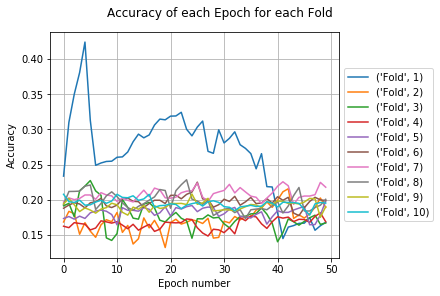

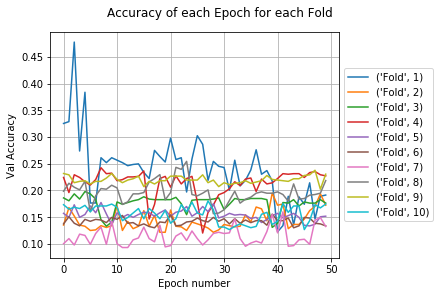

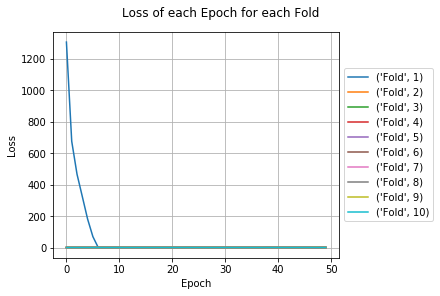

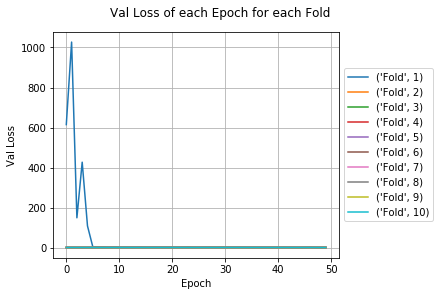

In [22]:
Graph_Epochs_model_1=Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_Loss_array_1)

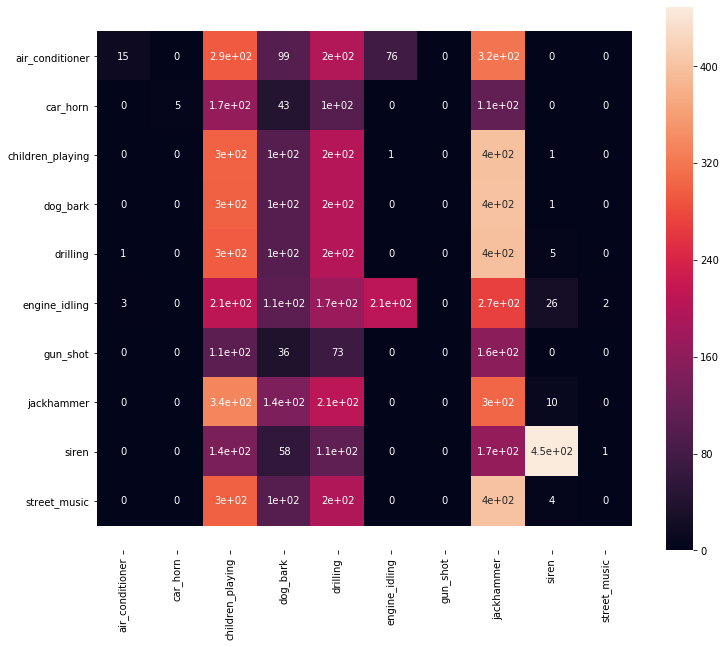

In [23]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [24]:
Table_model_1=table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time)

  Fold  Accuracy  Time Taken
0    1  0.263484     42.4231
1    2  0.171716     35.0033
2    3  0.176959     37.3957
3    4  0.165510     41.0799
4    5  0.181550     37.7947
5    6  0.197547     36.0757
6    7  0.207684     36.8272
7    8  0.197043     36.6118
8    9  0.191102     33.9358
9   10  0.194936     34.3079

    Average Accuracy  Total Time
0          0.194753    371.4551


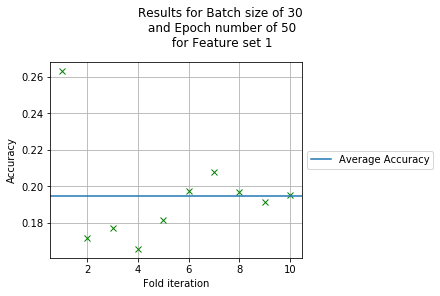

In [25]:
Graph_Avg_model_1=Graph_Avg_maker(Fold_accuracy,Avg_Accuracy)

### Model 1 no cross validation

In [26]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4))

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds_1[j] for j in range(0, len(Y_folds_1)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

Epoch_number=30

#compile model using accuracy to measure model performance
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
cnn_model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_1_no_cross=model.evaluate(X_test, y_test)
accuracy_model_1_no_cross = score_model_1_no_cross[1]
print(f"\nAccuracy of model 1 with no cross validation: {round(accuracy_model_1_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 1s - loss: 1.9665 - accuracy: 0.21 - ETA: 0s - loss: 2.0804 - accuracy: 0.19 - ETA: 0s - loss: 2.0636 - accuracy: 0.18 - ETA: 0s - loss: 2.0442 - accuracy: 0.19 - ETA: 0s - loss: 2.0474 - accuracy: 0.19 - ETA: 0s - loss: 2.0656 - accuracy: 0.18 - ETA: 0s - loss: 2.0694 - accuracy: 0.18 - ETA: 0s - loss: 2.0637 - accuracy: 0.18 - ETA: 0s - loss: 2.0637 - accuracy: 0.18 - ETA: 0s - loss: 2.0561 - accuracy: 0.18 - ETA: 0s - loss: 2.0531 - accuracy: 0.18 - ETA: 0s - loss: 2.0496 - accuracy: 0.18 - 1s 77us/step - loss: 2.0510 - accuracy: 0.1892 - val_loss: 2.1229 - val_accuracy: 0.1756
Epoch 2/30
7895/7895 [==============================] - ETA: 0s - loss: 2.0451 - accuracy: 0.34 - ETA: 0s - loss: 2.0172 - accuracy: 0.21 - ETA: 0s - loss: 2.0269 - accuracy: 0.20 - ETA: 0s - loss: 2.0324 - accuracy: 0.20 - ETA: 0s - loss: 2.0263 - accuracy: 0.20 - ETA: 0s - loss: 2.0363 - accuracy: 0.2

## Model 2

In [27]:
#adding layers and forming the model_1
#forming model_1
model_2=Sequential()
early_stopping_cb = EarlyStopping(patience=16, restore_best_weights=True)

    #add model layers
model_2.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(24,4,1)))
#model_2.add(Conv2D(32, kernel_size=3, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
    #compile model using accuracy to measure model performance
Model_2=model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
Accuracy_array_2=[]
accuracy_total_2=0
end_array_2=[]

Epoch_array_accuracy_2=[]
Loss_array_2=[]
Fold_accuracy_2=[]

Val_accuracy_array_2=[]
Val_Loss_array_2=[]

Avg_Accuracy_2=[]
Time_2=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_2=Model_run_nn_es(Model_2,model_2,X_folds_10,Y_folds_10,Accuracy_array_2,
                     accuracy_total_2,end_array_2,Epoch_array_accuracy_2,Loss_array_2,
                     Fold_accuracy_2,Val_accuracy_array_2,Val_Loss_array_2, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_2=Model_2[0]
Time_2=Model_2[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)
Accuracy of Fold 1 is 0.8275607824325562
Time to train Fold 1 : 52.0891 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.9429612755775452
Time to train Fold 2 : 17.9327 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.9455076456069946
Time to train Fold 3 : 21.2545 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.9493399262428284
Time to train Fold 4 : 18.0612 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.952215313911438
Time to train Fold 5 : 16.1198 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823

In [29]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
0, 0.5934304897698561, 0.625062646925882, 0.6105383734249714, 0.6105383734249714
1, 0.9195367874880124, 0.9271221353191306, 0.920045045045045, 0.920045045045045
2, 0.8765751527155744, 0.8811805472370821, 0.8756756756756757, 0.8756756756756757
3, 0.9041002897421567, 0.9081512601968067, 0.9040404040404041, 0.9040404040404041
4, 0.9421036839042609, 0.9425824946757243, 0.9423076923076923, 0.9423076923076923
5, 0.8916942221794946, 0.8988163247408381, 0.8918590522478737, 0.8918590522478737
6, 0.9022037682114847, 0.906341984686606, 0.9021479713603818, 0.9021479713603818
7, 0.9154608973000458, 0.9180597402874531, 0.9156327543424317, 0.9156327543424317
8, 0.9359931964652833, 0.9407138080116056, 0.9362745098039216, 0.9362745098039216
9, 0.929308677338312, 0.9341260937761843, 0.929510155316607, 0.929510155316607


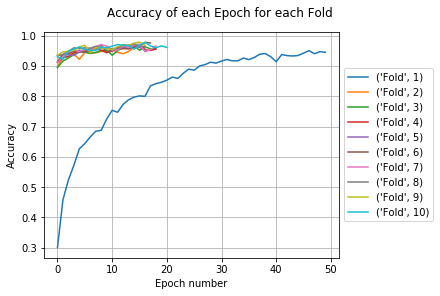

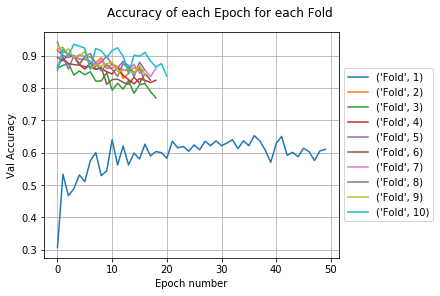

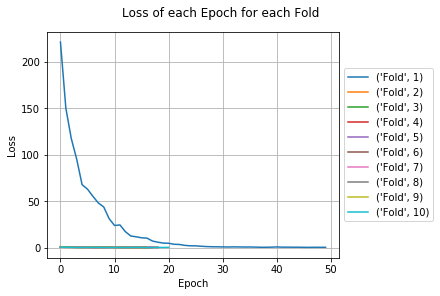

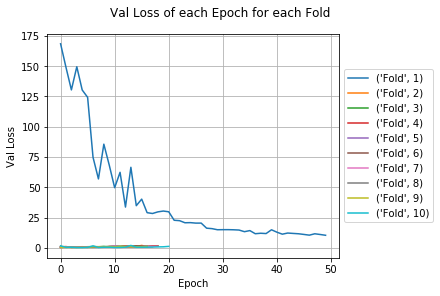

In [30]:
Graph_Epochs_model_2=Graph_func(Epoch_number,Epoch_array_accuracy_2,Val_accuracy_array_2,Loss_array_2,Val_Loss_array_2)

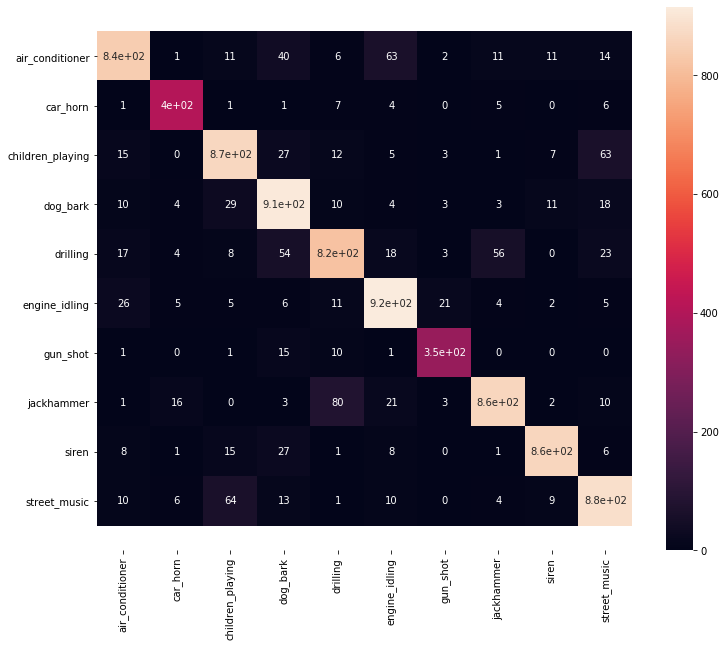

In [31]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [32]:
Table_model_2=table_maker(Fold_accuracy_2,end_array_2,Avg_Accuracy_2,Time_2)

  Fold  Accuracy  Time Taken
0    1  0.827561     52.0891
1    2  0.942961     17.9327
2    3  0.945508     21.2545
3    4  0.949340     18.0612
4    5  0.952215     16.1198
5    6  0.954862     17.8501
6    7  0.955522     18.2741
7    8  0.958855     17.2040
8    9  0.959992     19.7226
9   10  0.958889     21.1371

    Average Accuracy  Total Time
0           0.94057    219.6452


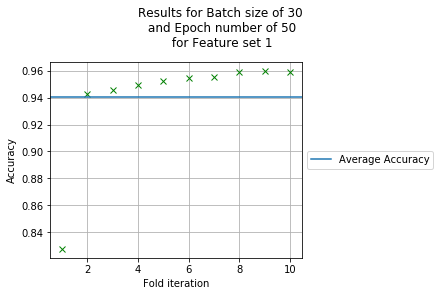

In [33]:
Graph_Avg_model_2=Graph_Avg_maker(Fold_accuracy_2,Avg_Accuracy_2)

### Model 2 no cross validation

In [34]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4,1))

Epoch_number=30
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

cnn_model_2_history = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_2_no_cross=model_2.evaluate(X_test, y_test)
accuracy_model_2_no_cross = score_model_2_no_cross[1]
print(f"\nAccuracy of model 2 with no cross validation: {round(accuracy_model_2_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 1.00 - ETA: 0s - loss: 0.3510 - accuracy: 0.95 - ETA: 0s - loss: 0.2810 - accuracy: 0.95 - ETA: 0s - loss: 0.2776 - accuracy: 0.95 - ETA: 0s - loss: 0.2981 - accuracy: 0.94 - ETA: 0s - loss: 0.3164 - accuracy: 0.94 - ETA: 0s - loss: 0.3120 - accuracy: 0.94 - ETA: 0s - loss: 0.2940 - accuracy: 0.94 - ETA: 0s - loss: 0.2830 - accuracy: 0.94 - ETA: 0s - loss: 0.2876 - accuracy: 0.94 - ETA: 0s - loss: 0.2758 - accuracy: 0.94 - ETA: 0s - loss: 0.2838 - accuracy: 0.94 - ETA: 0s - loss: 0.2714 - accuracy: 0.94 - ETA: 0s - loss: 0.2655 - accuracy: 0.94 - ETA: 0s - loss: 0.2563 - accuracy: 0.94 - ETA: 0s - loss: 0.2444 - accuracy: 0.95 - ETA: 0s - loss: 0.2521 - accuracy: 0.94 - ETA: 0s - loss: 0.2665 - accuracy: 0.94 - ETA: 0s - loss: 0.2709 - accuracy: 0.94 - ETA: 0s - loss: 0.2738 - accuracy: 0.94 - 1s 136us/step - loss: 0.2809 - accuracy: 0.9463 - val_los

## Model 3

In [35]:
model_3=Sequential()
early_stopping_cb = EarlyStopping(patience=17, restore_best_weights=True)

model_3.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(24,4,1)))
model_3.add(MaxPooling2D(padding="same"))

model_3.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model_3.add(MaxPooling2D(padding="same"))
model_3.add(Dropout(0.2))

model_3.add(Flatten())

model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))

model_3.add(Dense(10,activation="softmax"))

    #compiling
Model_3=model_3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [36]:
accuracy_total_3=0
end_array_3=[]

Epoch_array_accuracy_3=[]
Loss_array_3=[]
Fold_accuracy_3=[]

Val_accuracy_array_3=[]
Val_Loss_array_3=[]

Accuracy_array_3=[]
Avg_Accuracy_3=[]
Time_3=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_3=Model_run_nn_es(Model_3,model_3,X_folds_10,Y_folds_10,Accuracy_array_3,
                     accuracy_total_3,end_array_3,Epoch_array_accuracy_3,Loss_array_3,
                     Fold_accuracy_3,Val_accuracy_array_3,Val_Loss_array_3, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_3=Model_3[0]
Time_3=Model_3[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.24751751124858856
Time to train Fold 1 : 180.1125 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.48285311460494995
Time to train Fold 2 : 179.453 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.649813711643219
Time to train Fold 3 : 75.5335 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.6586682200431824
Time to train Fold 4 : 79.9597 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.652955949306488
Time to train Fold 5 : 64.2657 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823, 24, 4, 1) (823, 10)
Accuracy of Fold 6 is 0.6961268186569214
Time to train Fold 6 : 77.1442 seconds

In [37]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.12488516622234964, 0.24613340077257603, 0.21534936998854526, 0.21534936998854526
2, 0.5695646336204241, 0.6130822802931084, 0.5912162162162162, 0.5912162162162162
3, 0.7507533773350917, 0.7608295280687264, 0.7578378378378379, 0.7578378378378379
4, 0.7358756192950685, 0.7578697667006836, 0.7494949494949495, 0.7494949494949495
5, 0.7973657135895706, 0.7950944087188468, 0.8108974358974359, 0.8108974358974359
6, 0.741750805163227, 0.7369751330606225, 0.7606318347509113, 0.7606318347509113
7, 0.7546800338604995, 0.7520137519262642, 0.7744630071599046, 0.7744630071599046
8, 0.74402590286, 0.7501859894181381, 0.7555831265508685, 0.7555831265508685
9, 0.7323151721877352, 0.7371689123503908, 0.7426470588235294, 0.7426470588235294
10, 0.7998445739084332, 0.8065524508910462, 0.8112305854241338, 0.8112305854241338


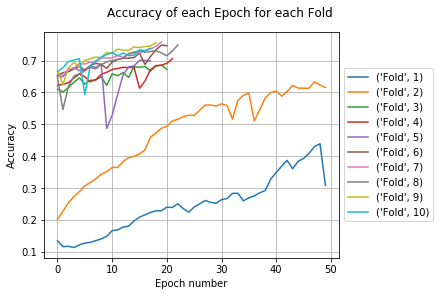

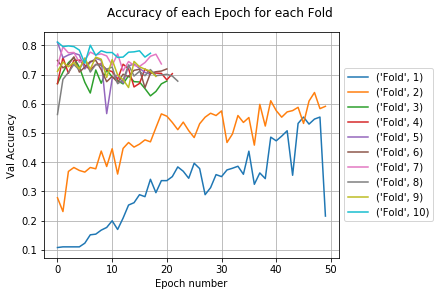

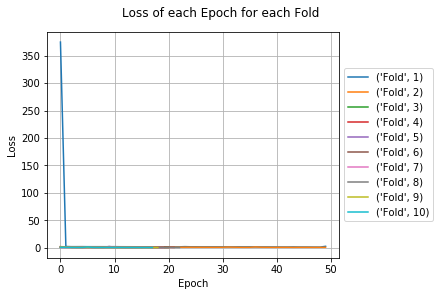

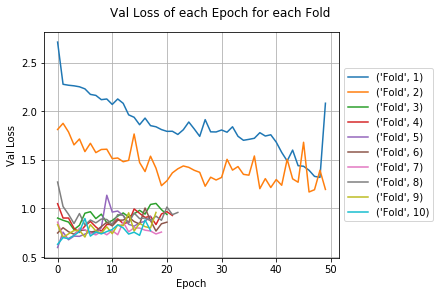

In [38]:
Graph_Epochs_model_3=Graph_func(Epoch_number,Epoch_array_accuracy_3,Val_accuracy_array_3,Loss_array_3,Val_Loss_array_3)

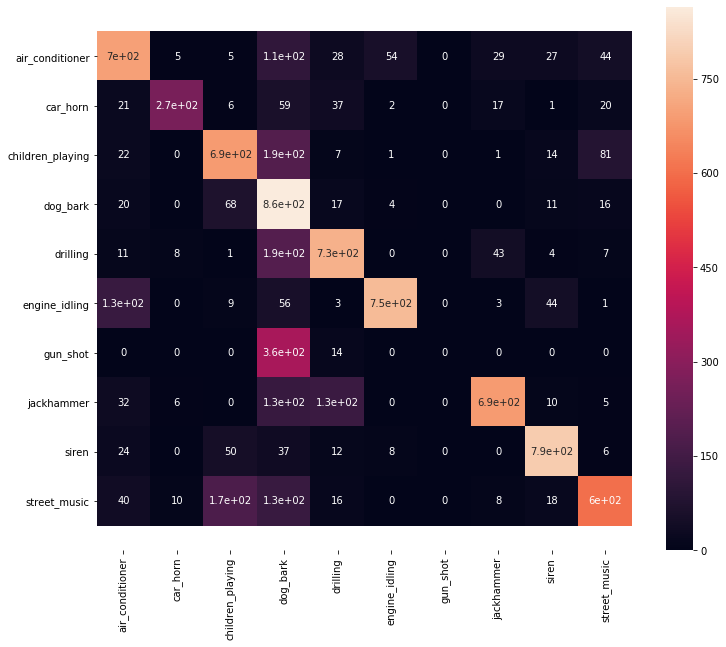

In [39]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [40]:
Table_model_3=table_maker(Fold_accuracy_3,end_array_3,Avg_Accuracy_3,Time_3)

  Fold  Accuracy  Time Taken
0    1  0.247518    180.1125
1    2  0.482853    179.4530
2    3  0.649814     75.5335
3    4  0.658668     79.9597
4    5  0.652956     64.2657
5    6  0.696127     77.1442
6    7  0.705384     72.5946
7    8  0.692224     85.4472
8    9  0.712940     66.6431
9   10  0.702723     66.7165

    Average Accuracy  Total Time
0          0.620121      947.87


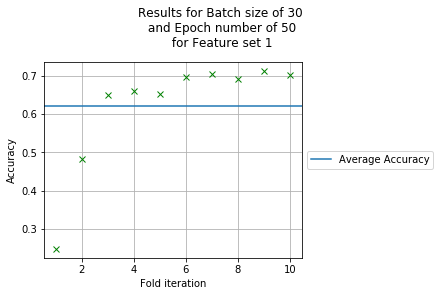

In [41]:
Graph_Avg_model_3=Graph_Avg_maker(Fold_accuracy_3,Avg_Accuracy_3)

### Model 3 no cross validation

In [42]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_3_history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_3_no_cross=model_3.evaluate(X_test, y_test)
accuracy_model_3_no_cross = score_model_3_no_cross[1]
print(f"\nAccuracy of model 3 with no cross validation: {round(accuracy_model_3_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 3s - loss: 0.8625 - accuracy: 0.68 - ETA: 3s - loss: 1.1061 - accuracy: 0.61 - ETA: 3s - loss: 1.0337 - accuracy: 0.66 - ETA: 3s - loss: 0.9691 - accuracy: 0.67 - ETA: 3s - loss: 0.9370 - accuracy: 0.66 - ETA: 3s - loss: 0.9185 - accuracy: 0.68 - ETA: 3s - loss: 0.9631 - accuracy: 0.66 - ETA: 3s - loss: 0.9434 - accuracy: 0.67 - ETA: 3s - loss: 0.9380 - accuracy: 0.67 - ETA: 3s - loss: 0.9463 - accuracy: 0.67 - ETA: 3s - loss: 0.9476 - accuracy: 0.67 - ETA: 3s - loss: 0.9458 - accuracy: 0.67 - ETA: 3s - loss: 0.9427 - accuracy: 0.67 - ETA: 3s - loss: 0.9365 - accuracy: 0.67 - ETA: 3s - loss: 0.9363 - accuracy: 0.67 - ETA: 3s - loss: 0.9350 - accuracy: 0.67 - ETA: 3s - loss: 0.9309 - accuracy: 0.67 - ETA: 3s - loss: 0.9258 - accuracy: 0.67 - ETA: 3s - loss: 0.9222 - accuracy: 0.67 - ETA: 3s - loss: 0.9246 - accuracy: 0.67 - ETA: 3s - loss: 0.9140 - accuracy: 0.68 - ETA: 3s - loss:

## Model 4

In [43]:
#adding layers and forming the model_1
#forming model_1
model_4=Sequential()

model_4.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(24,4,1)))
model_4.add(MaxPooling2D(padding="same"))

model_4.add(Flatten())

model_4.add(Dense(10,activation="softmax"))
#compiling
Model_4=model_4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [44]:
Accuracy_array_4=[]
accuracy_total_4=0
end_array_4=[]

Epoch_array_accuracy_4=[]
Loss_array_4=[]
Fold_accuracy_4=[]

Val_accuracy_array_4=[]
Val_Loss_array_4=[]

Avg_Accuracy_4=[]
Time_4=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_4=Model_run_nn_es_NO_EARLY_STOPPING(Model_4,model_4,X_folds_10,Y_folds_10,Accuracy_array_4,
                     accuracy_total_4,end_array_4,Epoch_array_accuracy_4,Loss_array_4,
                     Fold_accuracy_4,Val_accuracy_array_4,Val_Loss_array_4, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_4=Model_4[0]
Time_4=Model_4[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)
Accuracy of Fold 1 is 0.7225499153137207
Time to train Fold 1 : 90.1049 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.9035798907279968
Time to train Fold 2 : 81.6965 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.9321454763412476
Time to train Fold 3 : 83.4723 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.944701611995697
Time to train Fold 4 : 82.6019 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.9545433521270752
Time to train Fold 5 : 50.8491 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823

In [45]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.5772091742493699, 0.5843978402881982, 0.586483390607102, 0.586483390607102
2, 0.6978009498739552, 0.7248695795966883, 0.7083333333333334, 0.7083333333333334
3, 0.6627649544253588, 0.716664578954581, 0.6583783783783784, 0.6583783783783784
4, 0.8418590239815258, 0.8478665970504204, 0.8424242424242424, 0.8424242424242424
5, 0.8064905359095376, 0.8420665142655421, 0.8023504273504274, 0.8023504273504274
6, 0.8594542997606645, 0.8653757635986704, 0.8590522478736331, 0.8590522478736331
7, 0.9176075981927013, 0.9216608349029316, 0.9176610978520287, 0.9176610978520287
8, 0.8630160507081494, 0.8718708231826665, 0.8635235732009926, 0.8635235732009926
9, 0.834152899636547, 0.8453465721294984, 0.8370098039215687, 0.8370098039215687
10, 0.9084802249978186, 0.9151034093246291, 0.9091995221027479, 0.9091995221027479


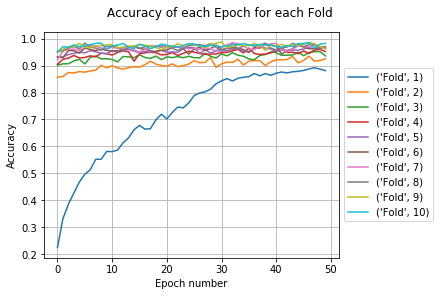

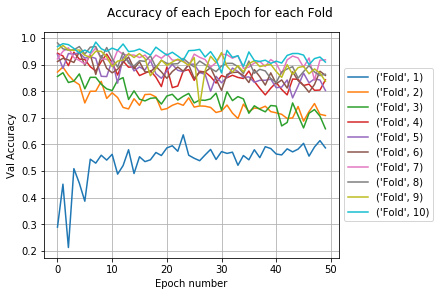

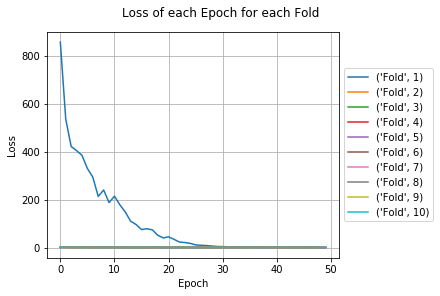

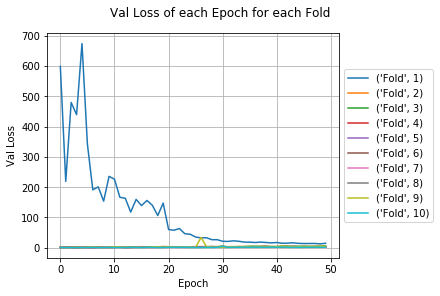

In [46]:
Graph_Epochs_model_4=Graph_func(Epoch_number,Epoch_array_accuracy_4,Val_accuracy_array_4,Loss_array_4,Val_Loss_array_4)

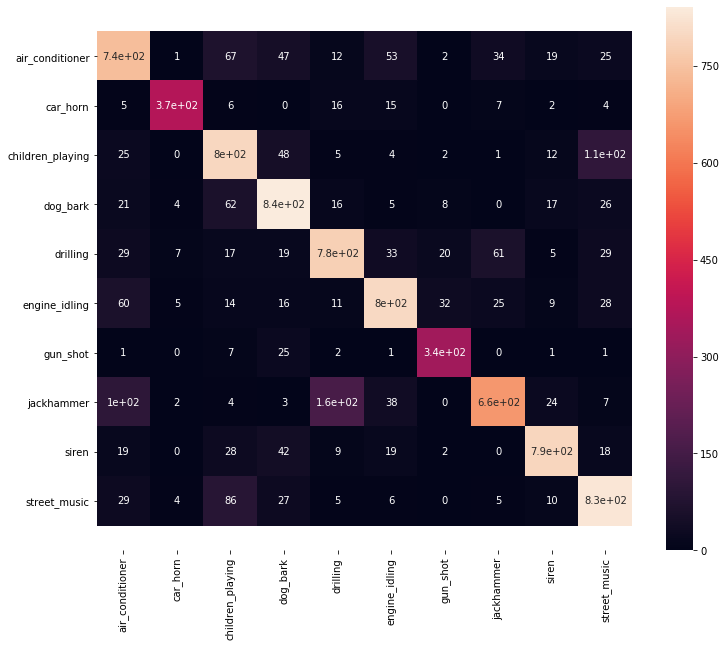

In [47]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [48]:
Table_model_4=table_maker(Fold_accuracy_4,end_array_4,Avg_Accuracy_4,Time_4)

  Fold  Accuracy  Time Taken
0    1  0.722550     90.1049
1    2  0.903580     81.6965
2    3  0.932145     83.4723
3    4  0.944702     82.6019
4    5  0.954543     50.8491
5    6  0.960622     40.2264
6    7  0.965951     41.2709
7    8  0.969546     42.4022
8    9  0.972948     42.7621
9   10  0.974214     41.1214

    Average Accuracy  Total Time
0           0.93008    596.5077


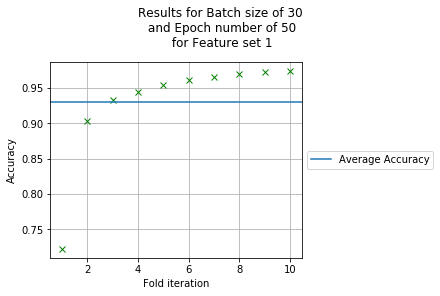

In [49]:
Graph_Avg_model_4=Graph_Avg_maker(Fold_accuracy_4,Avg_Accuracy_4)

In [50]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_4_history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_4_no_cross=model_4.evaluate(X_test, y_test)
accuracy_model_4_no_cross = score_model_4_no_cross[1]
print(f"\nAccuracy of model 4 with no cross validation: {round(accuracy_model_4_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 0s - loss: 0.4123 - accuracy: 0.96 - ETA: 0s - loss: 0.0906 - accuracy: 0.98 - ETA: 0s - loss: 0.3091 - accuracy: 0.98 - ETA: 0s - loss: 0.2969 - accuracy: 0.97 - ETA: 0s - loss: 0.3376 - accuracy: 0.97 - ETA: 0s - loss: 0.6819 - accuracy: 0.97 - ETA: 0s - loss: 0.6960 - accuracy: 0.96 - ETA: 0s - loss: 0.7401 - accuracy: 0.96 - ETA: 0s - loss: 0.6898 - accuracy: 0.96 - ETA: 0s - loss: 0.6410 - accuracy: 0.96 - ETA: 0s - loss: 0.5938 - accuracy: 0.96 - ETA: 0s - loss: 0.5701 - accuracy: 0.96 - ETA: 0s - loss: 0.5586 - accuracy: 0.96 - ETA: 0s - loss: 0.5439 - accuracy: 0.96 - ETA: 0s - loss: 0.5675 - accuracy: 0.96 - ETA: 0s - loss: 0.5387 - accuracy: 0.96 - 1s 107us/step - loss: 0.5402 - accuracy: 0.9693 - val_loss: 1.6238 - val_accuracy: 0.9092
Epoch 2/30
7895/7895 [==============================] - ETA: 0s - loss: 3.7253e-09 - accuracy: 1.00 - ETA: 0s - loss: 0.3835 - accuracy

## Model from Github

In [51]:
# Model from GitHub

#adding layers and forming the model

#forming model
model_5=Sequential()

model_5.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(24,4,1)))
model_5.add(MaxPooling2D(padding="same"))

model_5.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model_5.add(MaxPooling2D(padding="same"))
model_5.add(Dropout(0.3))

model_5.add(Flatten())

model_5.add(Dense(256,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(512,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(10,activation="softmax"))

#compiling
Model_5=model_5.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [52]:
Accuracy_array_5=[]
accuracy_total_5=0
end_array_5=[]

Epoch_array_accuracy_5=[]
Loss_array_5=[]
Fold_accuracy_5=[]

Val_accuracy_array_5=[]
Val_Loss_array_5=[]

Avg_Accuracy_5=[]
Time_5=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_5=Model_run_nn_es_NO_EARLY_STOPPING(Model_5,model_5,X_folds_10,Y_folds_10,Accuracy_array_5,
                     accuracy_total_5,end_array_5,Epoch_array_accuracy_5,Loss_array_5,
                     Fold_accuracy_5,Val_accuracy_array_5,Val_Loss_array_5, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_5=Model_5[0]
Time_5=Model_5[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.11243415623903275
Time to train Fold 1 : 295.3729 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.11190973967313766
Time to train Fold 2 : 380.7234 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.11110030114650726
Time to train Fold 3 : 447.9189 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.11160165816545486
Time to train Fold 4 : 368.16 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.11067213863134384
Time to train Fold 5 : 405.9082 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823, 24, 4, 1) (823, 10)
Accuracy of Fold 6 is 0.11747628450393677
Time to train Fold 6 : 406.784

In [53]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.02354522861828357, 0.013121138284988499, 0.1145475372279496, 0.1145475372279496
2, 0.02279607542765438, 0.012681600519438356, 0.11261261261261261, 0.11261261261261261
3, 0.02109426499670402, 0.01168736303871439, 0.10810810810810811, 0.10810810810810811
4, 0.01853396348809193, 0.010203040506070809, 0.10101010101010101, 0.10101010101010101
5, 0.020625020625020623, 0.011414274234787055, 0.10683760683760683, 0.10683760683760683
6, 0.012611602729059193, 0.006826815329035078, 0.08262454434993925, 0.08262454434993925
7, 0.015082278844597171, 0.008225061374678887, 0.09069212410501193, 0.09069212410501193
8, 0.017077798861480076, 0.009365244536940686, 0.0967741935483871, 0.0967741935483871
9, 0.018352329796060964, 0.010098279507881584, 0.10049019607843138, 0.10049019607843138
10, 0.02222222222222222, 0.012345679012345678, 0.1111111111111111, 0.1111111111111111


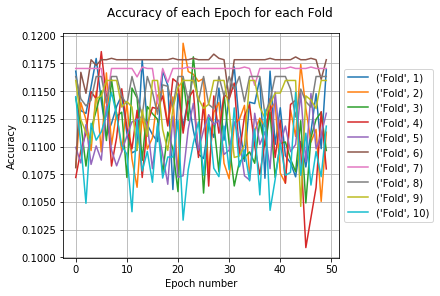

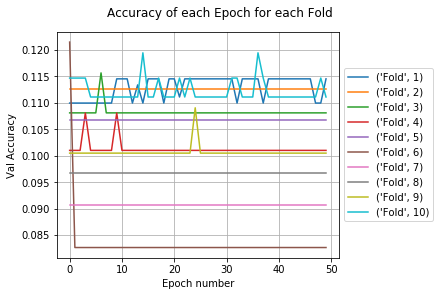

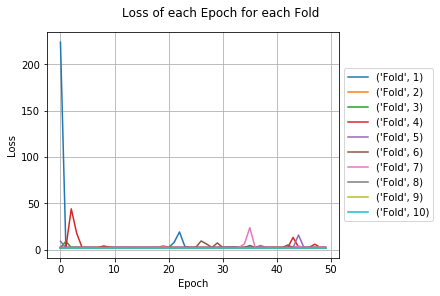

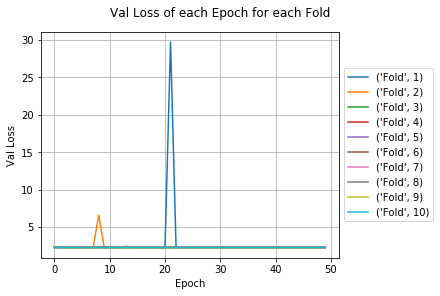

In [54]:
Graph_Epochs_model_5=Graph_func(Epoch_number,Epoch_array_accuracy_5,Val_accuracy_array_5,Loss_array_5,Val_Loss_array_5) 

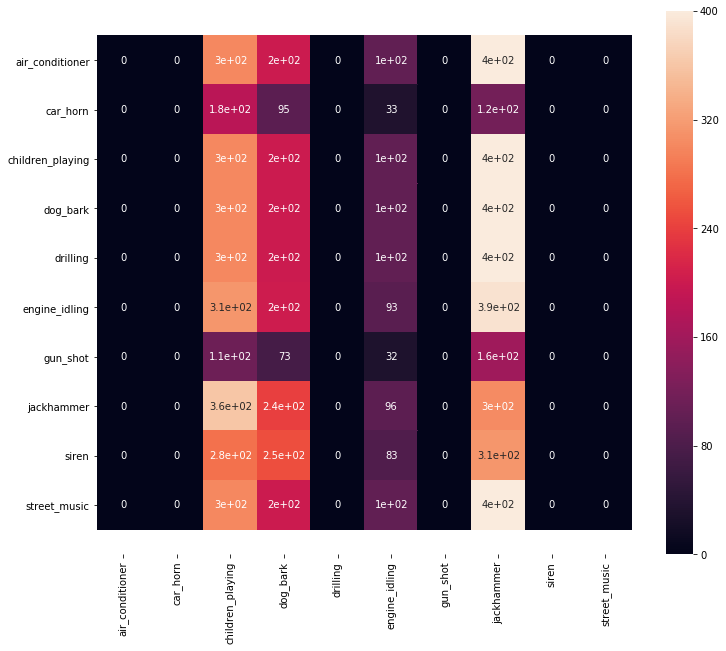

In [55]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [56]:
Table_model_5=table_maker(Fold_accuracy_5,end_array_5,Avg_Accuracy_5,Time_5)

  Fold  Accuracy  Time Taken
0    1  0.112434    295.3729
1    2  0.111910    380.7234
2    3  0.111100    447.9189
3    4  0.111602    368.1600
4    5  0.110672    405.9082
5    6  0.117476    406.7844
6    7  0.116866    384.8949
7    8  0.115135    390.7822
8    9  0.113820    277.0807
9   10  0.109543    336.0315

    Average Accuracy  Total Time
0          0.113056   3693.6571


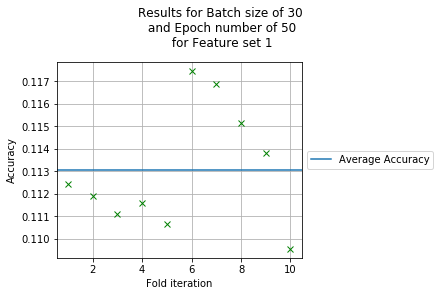

In [57]:
Graph_Avg_model_5=Graph_Avg_maker(Fold_accuracy_5,Avg_Accuracy_5)

### Github model with no cross validation

In [58]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_5_history = model_5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_5_no_cross=model_5.evaluate(X_test, y_test)
accuracy_model_5_no_cross = score_model_5_no_cross[1]
print(f"\nAccuracy of model 5 with no cross validation: {round(accuracy_model_5_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 3s - loss: 2.3388 - accuracy: 0.09 - ETA: 3s - loss: 2.2638 - accuracy: 0.07 - ETA: 3s - loss: 2.2662 - accuracy: 0.08 - ETA: 3s - loss: 2.2727 - accuracy: 0.09 - ETA: 4s - loss: 2.2672 - accuracy: 0.08 - ETA: 4s - loss: 2.2689 - accuracy: 0.09 - ETA: 4s - loss: 2.2720 - accuracy: 0.09 - ETA: 4s - loss: 2.2673 - accuracy: 0.09 - ETA: 4s - loss: 2.2735 - accuracy: 0.09 - ETA: 4s - loss: 2.2720 - accuracy: 0.10 - ETA: 4s - loss: 2.2713 - accuracy: 0.10 - ETA: 5s - loss: 2.2674 - accuracy: 0.10 - ETA: 5s - loss: 2.2660 - accuracy: 0.10 - ETA: 5s - loss: 2.2672 - accuracy: 0.11 - ETA: 5s - loss: 2.2704 - accuracy: 0.11 - ETA: 5s - loss: 2.2722 - accuracy: 0.11 - ETA: 5s - loss: 2.2706 - accuracy: 0.11 - ETA: 5s - loss: 2.2682 - accuracy: 0.11 - ETA: 5s - loss: 2.2682 - accuracy: 0.11 - ETA: 5s - loss: 2.2653 - accuracy: 0.11 - ETA: 5s - loss: 2.2671 - accuracy: 0.11 - ETA: 5s - loss:

### Model comparisson

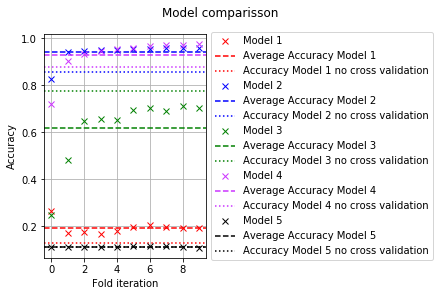

In [59]:
%matplotlib inline

 

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

 

ax1.plot(Fold_accuracy,"rx",label="Model 1")
ax1.axhline(y=Avg_Accuracy,label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")

 


ax1.plot(Fold_accuracy_2,"bx",label="Model 2")
ax1.axhline(y=Avg_Accuracy_2,label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")

 


ax1.plot(Fold_accuracy_3,"gx",label="Model 3")
ax1.axhline(y=Avg_Accuracy_3,label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

 

ax1.plot(Fold_accuracy_4,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=Avg_Accuracy_4,label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

 

ax1.plot(Fold_accuracy_5,"kx",label="Model 5")
ax1.axhline(y=Avg_Accuracy_5,label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

 

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_folds, Y_folds = data_processor_log_reg(X_folds,Y_folds)

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of logistic regression classifier on test set: 0.66


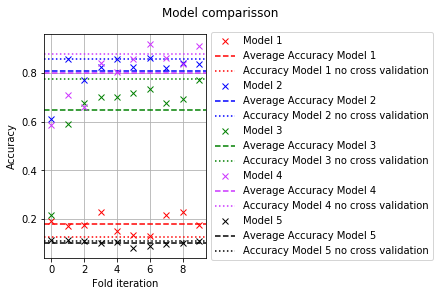

In [61]:
Val_accuracy_array_fix = [Val_accuracy_array[i][-1] for i in range(10)]
Val_accuracy_array_2_fix = [Val_accuracy_array_2[i][-1] for i in range(10)]
Val_accuracy_array_3_fix = [Val_accuracy_array_3[i][-1] for i in range(10)]
Val_accuracy_array_4_fix = [Val_accuracy_array_4[i][-1] for i in range(10)]
Val_accuracy_array_5_fix = [Val_accuracy_array_5[i][-1] for i in range(10)]

 

%matplotlib inline

 

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

 

ax1.plot(Val_accuracy_array_fix,"rx",label="Model 1")
ax1.axhline(y=np.average(Val_accuracy_array_fix),label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")

 


ax1.plot(Val_accuracy_array_2_fix,"bx",label="Model 2")
ax1.axhline(y=np.average(Val_accuracy_array_2_fix),label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")

 


ax1.plot(Val_accuracy_array_3_fix,"gx",label="Model 3")
ax1.axhline(y=np.average(Val_accuracy_array_3_fix),label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

 

ax1.plot(Val_accuracy_array_4_fix,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=np.average(Val_accuracy_array_4_fix),label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

 

ax1.plot(Val_accuracy_array_5_fix,"kx",label="Model 5")
ax1.axhline(y=np.average(Val_accuracy_array_5_fix),label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

 

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))